In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import networkx as nx

from scipy.integrate import solve_ivp

# Testing BOPDMD reconstruction
## Loading the A matrix

In [2]:
with open('A_struc_causal_inference.pkl', 'rb') as f:
    A = pickle.load(f)

## Visualize the eigenvalues of the matrix

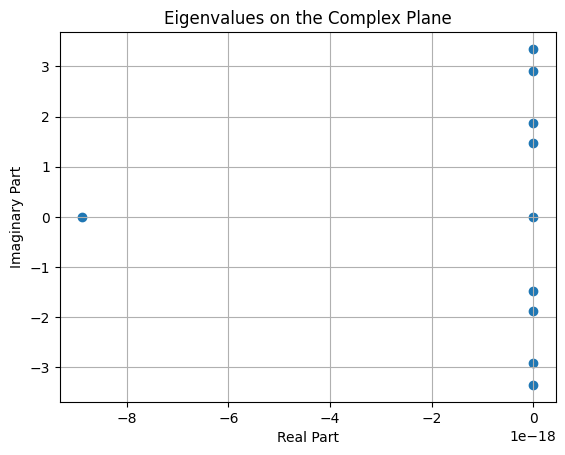

In [3]:
eigenvalues = np.linalg.eigvals(A)

# Plot the eigenvalues on the complex plane
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues on the Complex Plane')
plt.grid(True)
plt.show()

## Visualize the "sparse structure" of the matrix

16


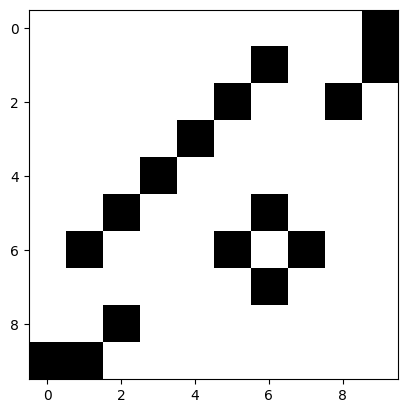

In [7]:
plt.imshow(A!=0, cmap='binary')
print(np.count_nonzero(A))

## Visualize the "network structure"

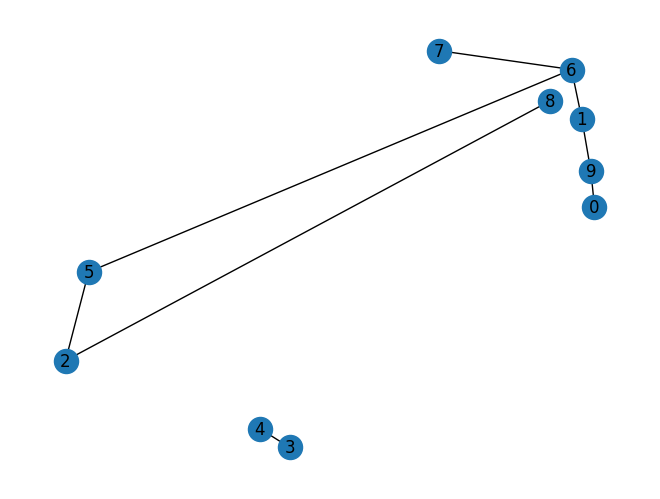

In [6]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(A)

# Compute the layout using the spring layout algorithm
pos = nx.spring_layout(G)

# Draw the graph with nodes pulled apart based on forces
nx.draw(G, pos, with_labels=True)

# Show the graph
plt.show()

## Generate the dynamics data

In [9]:
# Generate a random initial condition for the 10 state variables
initial_condition = np.random.rand(10)

# Define the function that represents the system dynamics
def system_dynamics(t, x):
    return np.dot(A, x)

# Simulate the system between 0 and 50
solution = solve_ivp(system_dynamics, [0,10], initial_condition, t_eval=np.linspace(0,10,1000))

# Get the time points and state variables from the solution
time_points = solution.t
state_variables = np.transpose(solution.y)

## Plot the dynamics of the system

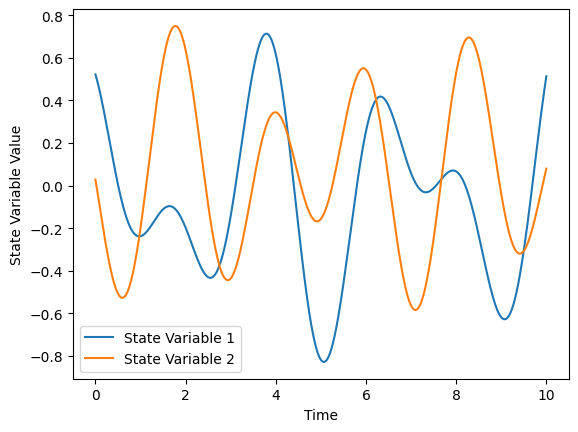

In [11]:
# Extract all state variables
state_var1 = state_variables[:, 0]
state_var2 = state_variables[:, 1]
# state_var2 = state_variables[:, 1]
# state_var3 = state_variables[:, 2]
# state_var4 = state_variables[:, 3]
# state_var5 = state_variables[:, 4]
# state_var6 = state_variables[:, 5]
# state_var7 = state_variables[:, 6]
# state_var8 = state_variables[:, 7]
# state_var9 = state_variables[:, 8]
# state_var10 = state_variables[:, 9]

# Plot the evolution of all state variables
plt.plot(time_points, state_var1, label='State Variable 1')
plt.plot(time_points, state_var2, label='State Variable 2')
# plt.plot(state_var2, label='State Variable 2')
# plt.plot(state_var3, label='State Variable 3')
# plt.plot(state_var4, label='State Variable 4')
# plt.plot(state_var5, label='State Variable 5')
# plt.plot(state_var6, label='State Variable 6')
# plt.plot(state_var7, label='State Variable 7')
# plt.plot(state_var8, label='State Variable 8')
# plt.plot(state_var9, label='State Variable 9')
# plt.plot(state_var10, label='State Variable 10')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('State Variable Value')
plt.legend()

# Show the plot
plt.show()

## Rearranging the data

In [12]:
Xn = np.transpose(state_variables)
t = time_points

## Apply exact DMD

In [13]:
from pydmd import DMD

dmd = DMD(svd_rank=0, tlsq_rank=2, exact=True, opt=True)
dmd.fit(Xn)

Aexa = np.linalg.multi_dot([dmd.modes, np.diag(dmd.eigs), np.linalg.pinv(dmd.modes)])

/Users/fmenol/miniconda3/envs/dmd/lib/python3.8/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 3961256278739635.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


## Apply Sparse BOPDMD

In [16]:
from pydmd.bopdmd import BOPDMD

def hard_threshold(X, gamma=0.01):
    # Hard thresholding for L0 norm.
    X[np.abs(X) ** 2 < 2 * gamma] = 0.0
    return X

def soft_threshold(X, gamma=0.05):
    # Soft thresholding for L1 norm.
    return np.sign(X) * np.maximum(np.abs(X) - gamma, 0.0)

bopdmd = BOPDMD(
    svd_rank=0,
    num_trials=0,
    trial_size=0.8,
    varpro_opts_dict={"verbose":True, "tol":0.8},
    eig_constraints={"imag"},
    use_proj=False,
    mode_proxy=hard_threshold,
    compute_A=True
)

bopdmd.fit(Xn, t)

Step 1 Error 0.7425761716843393 Lambda 1.0502651340802143
Convergence reached!


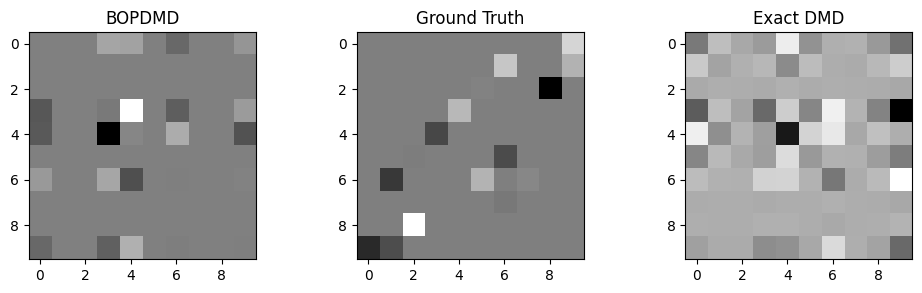

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(np.real(bopdmd.A), cmap='binary')
axs[0].set_title('BOPDMD')
axs[1].imshow(A, cmap='binary')
axs[1].set_title('Ground Truth')
axs[2].imshow(np.real(Aexa), cmap='binary')
axs[2].set_title('Exact DMD')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()